# Imports

In [1]:
import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# data import

In [2]:
df = pd.read_csv("data/covid/france/hospitalisations/donnees-hospitalieres-covid19-2020-05-05-19h00.csv", sep=";")

# data exploration

In [3]:
df.head()

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6


In [4]:
df.describe()

,sexe,hosp,rea,rad,dc
count,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000
mean,1.000000,157.342357,31.414074,167.986465,55.095825
std,0.816524,300.362171,64.017471,335.232762,120.594982
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,3.000000,15.000000,3.000000
50%,1.000000,52.000000,10.000000,50.000000,14.000000
75%,2.000000,142.000000,29.000000,161.000000,47.000000
max,2.000000,3281.000000,855.000000,4341.000000,1542.000000


In [5]:
df.columns

Index(['dep', 'sexe', 'jour', 'hosp', 'rea', 'rad', 'dc'], dtype='object')

In [6]:
df.dtypes

dep     object
sexe     int64
jour    object
hosp     int64
rea      int64
rad      int64
dc       int64
dtype: object

Il sera intéressant pour la suite d'avoir des datetime pour les jour au lieu de simple string.

In [7]:
df["jour"] = pd.to_datetime(df["jour"])

## des plots

### sexe

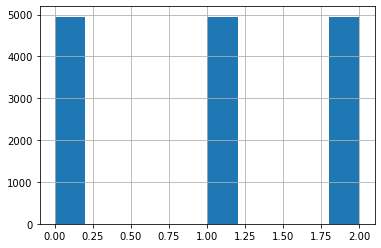

In [8]:
df["sexe"].hist()

Le sexe est codé en trois valeurs 0 1 2.
Le codage utilisé est indiqué dans le fichier de métadonnées sexe (/data/covid/hospitalisations/metadonnees-sexe.csv).

Une ligne avec le sexe à 1 correspond aux données pour les hommes, à 2 pour les femmes, et les lignes à 0 correspondent aux aggregats des lignes homme et femmes + les hospitalisations de personnes dont le sexe n'est pas identifié / ou valeur manquante. On pourra donc observer des décalages entre la somme H + F et le total final.

(Source: https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/

> Pour certains patients, le sexe n'a pas été identifié dans la base de données. Ce qui peut induire un décalage entre la somme H/F d'un indicateur et le nombre total de cet indicateur. 

)

La fréquence de chaque sexe dans la base est la même car pour chaque jour on a :
- une ligne pour les hommes
- une ligne pour les femmes
- une ligne pour le total

L'histogramme ne donne donc pas d'information sur la quantité d'hommes ou de femmes. Pour obtenir cette valeur on doit calculer l'aggregat de la colonne souhaitée.

In [9]:
# Identification du nombre de cas à valeur manquante
df["total"] = df["hosp"] + df["rea"] + df["rad"] + df["dc"]
df

,dep,sexe,jour,hosp,rea,rad,dc,total
0,01,0,2020-03-18,2,0,1,0,3
1,01,1,2020-03-18,1,0,1,0,2
2,01,2,2020-03-18,1,0,0,0,1
3,02,0,2020-03-18,41,10,18,11,80
4,02,1,2020-03-18,19,4,11,6,40
...,...,...,...,...,...,...,...,...
14845,974,1,2020-05-05,4,2,54,0,60
14846,974,2,2020-05-05,1,0,58,0,59
14847,976,0,2020-05-05,44,6,105,11,166
14848,976,1,2020-05-05,28,5,54,8,95


On calcule le différentiel entre le total pour sexe 0 et la somme des sexe 1 et 2

In [10]:
total_sum = df.groupby("sexe").sum()
total_sum

,hosp,rea,rad,dc,total
sexe,,,,,
0,1173932,234301,1252411,410431,3071075
1,640890,171299,664736,244626,1721551
2,521712,60899,577452,163116,1323179


In [11]:
nb = total_sum["total"][0] - (total_sum["total"][1] + total_sum["total"][2])
print(f"On observe {nb} valeurs manquantes pour le sexe sur la totalité des observations")

On observe 26345 valeurs manquantes pour le sexe sur la totalité des observations


Les enregistrements étant conservés, les cas à valeurs manquantes sont cumulées. Ce qui veut dire qu'il n'y a pas 26345 valeurs manquantes uniques.

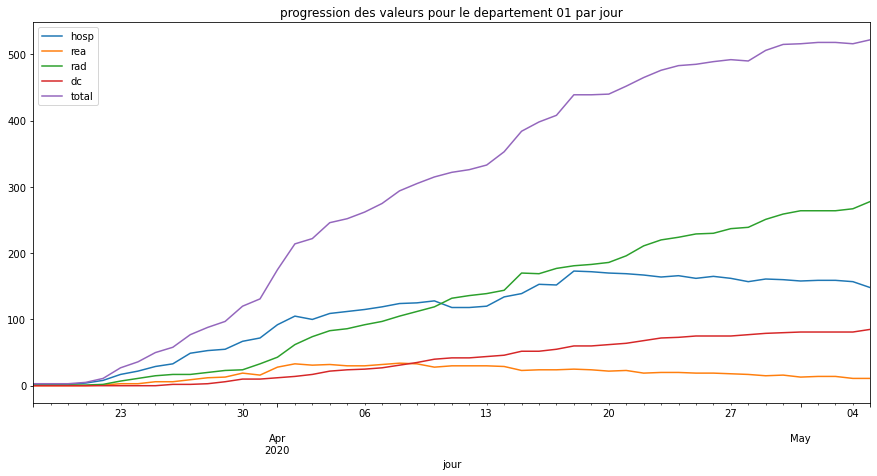

In [12]:
fig, ax = plt.subplots()

fig.set_size_inches(15,7)

tmp = df[np.logical_and(df["dep"] == "01", df["sexe"] == 0)]
tmp[["jour", "hosp"]].pivot_table(index="jour").plot(ax=ax)
tmp[["jour", "rea"]].pivot_table(index="jour").plot(ax=ax)
tmp[["jour", "rad"]].pivot_table(index="jour").plot(ax=ax)
tmp[["jour", "dc"]].pivot_table(index="jour").plot(ax=ax)
tmp[["jour", "total"]].pivot_table(index="jour").plot(ax=ax)

plt.title("progression des valeurs pour le departement 01 par jour")
plt.show()

On observe bien que les variables comme retour à domicile ou décès sont croissantes.

Pour obtenir le véritable nombre de cas à sexe non identifié on doit seulement prendre en compte le différentiel chaque jour.

Ces valeurs sont disponibles dans le jeu de données "hospitalisations nouveaux".

La colonne rad (retour à domicile) fonctionne comme dc en cumulé. Les colonnes hosp et rea sont quotidiennes et non cumulées.